In [7]:
# N.B. Activate .env ?
import numpy as np
import pandas as pd
import os
from datetime import datetime
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
#from transformers import BertTokenizer, BertModel, BertConfig
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from prep_input_data import get_vectorized_labelled_data


In [8]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print("Using device: " + device)

Using device: cpu


In [69]:
# Corpus and dictionary files to use
corpus_file = '../../data/democracy_reports_corpus_290724.csv'
output_label_column = 'dimension0'
input_label_column = 'dimension0'
DROP_AMBIGUOUS = True
BALANCE_LABELS = False

In [70]:
df = pd.read_csv(corpus_file, dtype={'year': str},comment='#')

# Drop ambigous class
if (DROP_AMBIGUOUS == True):
    df['dimension0'] = df['dimension0'].replace({'ambiguous': None})
    #global corpus_file
    corpus_file = './temp_data.csv'
    df.to_csv(corpus_file, index=False)

/tmp/ipykernel_3560594/3032261243.py:1: DtypeWarning: Columns (4,5,6,8,9,10,12,13,14,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(corpus_file, dtype={'year': str},comment='#')


In [71]:
print(corpus_file)
#df_labelled = get_vectorized_labelled_data(corpus_file, column=input_label_column, group_by_idea=True)
df_labelled = get_vectorized_labelled_data(corpus_file, column=input_label_column, group_by_idea=False)
#print(df_labelled.sample(1))
print(df_labelled[input_label_column].value_counts())

./temp_data.csv


/data/smurf_storage/backdem/democracy-text-classification/notebooks/prep_input_data.py:84: DtypeWarning: Columns (4,5,6,8,9,10,12,13,14,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(corpus_file, dtype={'year': str},comment='#')


dimension0
liberal          2334
electoral        1092
participatory     569
media             475
Name: count, dtype: int64


In [72]:
if (BALANCE_LABELS == True):
    from imblearn.under_sampling import RandomUnderSampler
    # Separate features and labels
    X = df_labelled.drop(input_label_column, axis=1)
    y = df_labelled[input_label_column]

    # Apply RandomUnderSampler
    undersampler = RandomUnderSampler()
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

    # Combine resampled features and labels into a DataFrame
    df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
    df_labelled = df_resampled

    print(df_resampled[input_label_column].value_counts())

In [73]:
# Get label names
labels = sorted(df_labelled[output_label_column].dropna().unique())
print(f'Labels: {labels}')

Labels: ['electoral', 'liberal', 'media', 'participatory']


<Axes: ylabel='dimension0'>

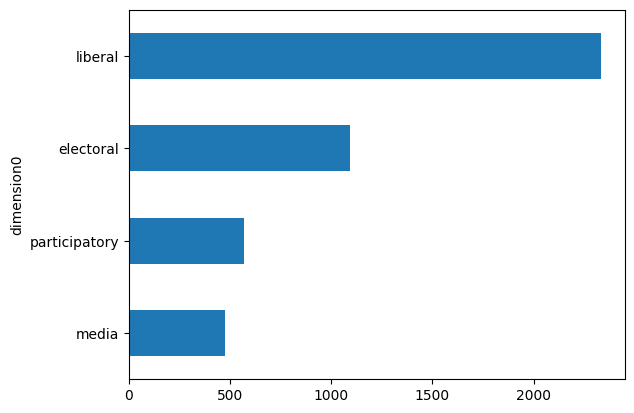

In [74]:
# Count the different classes to check how balanced they are
value_counts_dimension1 = df_labelled[output_label_column].value_counts()
value_counts_dimension1.sort_values().plot(kind="barh")

In [75]:
FRACTION_OF_DS_TO_USE = 1
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-05
NO_LABELS = len(labels)
MAX_LOSS = 0.01

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


In [76]:
# Use part of the dataset
new_df = df_labelled.sample(frac=FRACTION_OF_DS_TO_USE, random_state=200)
# Display a sample of the dataset
new_df.sample(10)[['sentence', 'dimension0', 'label_vector']]

,sentence,dimension0,label_vector
455438,the draft law on the judicial appointments com...,liberal,"[0, 1, 0, 0]"
454014,"in 2019, the disposition time continued to dec...",liberal,"[0, 1, 0, 0]"
587,"""Members of some minority religions face discr...",liberal,"[0, 1, 0, 0]"
25114,"""The Office of the UN High Commissioner for Hu...",liberal,"[0, 1, 0, 0]"
455569,general rules and procedures concerning confli...,liberal,"[0, 1, 0, 0]"
1417,"""While the SNS and its coalition partners won ...",electoral,"[1, 0, 0, 0]"
882,"""Media coverage was largely biased in favor of...",media,"[0, 0, 1, 0]"
457826,the government is considering to strengthen th...,liberal,"[0, 1, 0, 0]"
311,"""The AfD held seats in the Bundestag and all s...",electoral,"[1, 0, 0, 0]"
63370,"""A total of 14 complaints were lodged by Davko...",electoral,"[1, 0, 0, 0]"


In [77]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.sentence
        self.targets = self.data.label_vector
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [78]:
train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (4470, 24)
TRAIN Dataset: (3576, 24)
TEST Dataset: (894, 24)


<Axes: ylabel='dimension0'>

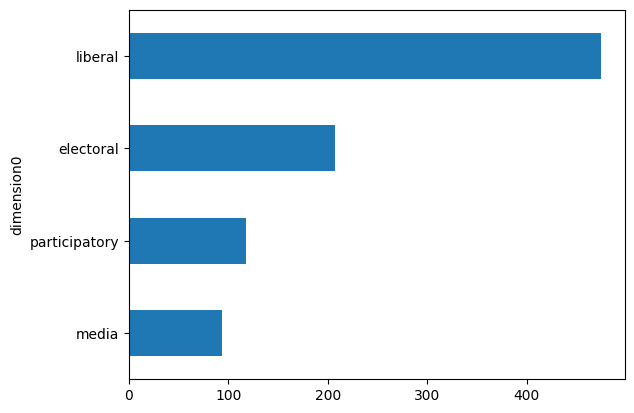

In [79]:
#value_counts_dimension1_train = train_dataset[output_label_column].value_counts()
#value_counts_dimension1_train.sort_values().plot(kind="barh")
value_counts_dimension1_test = test_dataset[output_label_column].value_counts()
value_counts_dimension1_test.sort_values().plot(kind="barh")

In [80]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [81]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class ROBERTAClass(torch.nn.Module):
    def __init__(self):
        super(ROBERTAClass, self).__init__()
        self.l1 = transformers.RobertaModel.from_pretrained('roberta-base')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, NO_LABELS)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = ROBERTAClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROBERTAClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [82]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [83]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [84]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        if loss.item() < MAX_LOSS:
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [85]:
# Train
for epoch in range(EPOCHS):
    loss = train(epoch)
    print(f'Epoch {epoch} done')
    if loss.item() < MAX_LOSS:
        print(f'Loss minimized to below {MAX_LOSS}')
        break

Epoch: 0, Loss:  0.7086969017982483
Epoch 0 done
Epoch: 1, Loss:  0.12309616804122925
Epoch 1 done
Epoch: 2, Loss:  0.1718653291463852
Epoch 2 done
Epoch: 3, Loss:  0.4586658775806427
Epoch 3 done
Epoch: 4, Loss:  0.0157900582998991
Epoch 4 done
Loss minimized to below 0.01


In [86]:
from sklearn.metrics import confusion_matrix
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [87]:
from sklearn.metrics import confusion_matrix
def validation_w_confusion():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    i_labels = []
    with torch.no_grad():
        for i, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            i_labels.append(test_dataset.iloc[i][output_label_column])
            #print(ids)
            #print(targets)
            #print(fin_targets)
            #print(fin_outputs)
            #break

    # Convert lists to numpy arrays
    fin_targets = np.array(fin_targets)
    fin_outputs = np.array(fin_outputs)
    
    # Get predicted labels by thresholding the predicted probabilities
    predicted_labels = (fin_outputs > 0.5).astype(int)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(fin_targets.argmax(axis=1), predicted_labels.argmax(axis=1))
    return fin_outputs, fin_targets, conf_matrix, i_labels
    #return fin_outputs, fin_targets

In [88]:
# Validation
outputs, targets, confusion_matrix, f_labels = validation_w_confusion()
outputs_a = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs_a)
f1_score_micro = metrics.f1_score(targets, outputs_a, average='micro', zero_division=1)
f1_score_macro = metrics.f1_score(targets, outputs_a, average='macro', zero_division=1)

In [89]:
# Check https://stephenallwright.com/micro-vs-macro-f1-score/
result_string = f"Accuracy Score = {accuracy}\n"
result_string += f"F1 Score (Micro) = {f1_score_micro}\n"
result_string += f"F1 Score (Macro) = {f1_score_macro}\n"
result_string += f"{sorted(set(f_labels))}\n"
result_string += f"{confusion_matrix}\n"
print(result_string)


Accuracy Score = 0.8456375838926175
F1 Score (Micro) = 0.8512304250559284
F1 Score (Macro) = 0.8244525876878819
['electoral', 'liberal', 'media', 'participatory']
[[182  20   2   3]
 [ 22 423   7  23]
 [  1  10  81   2]
 [ 13  31   1  73]]



In [90]:
# Test our inputs
# Choose a sentence
#sample_row = new_df.sample()[['sentence', 'label_vector']]
sample_row = df_labelled.sample()[['sentence']]
sample_text = sample_row['sentence'].values[0]
print(sample_text)

"People’s political choices are free from domination by powerful groups that are not democratically accountable.


In [91]:
def get_dimension_from_prediction(v, l=labels):    
    index = v.index(max(v))
    if max(v) < 0.5:
        return "NoClass"
    else:
        return l[index]
    
# Encode the sentence
encoding = tokenizer.encode_plus(
  sample_text.lower(),
  add_special_tokens=True,
  max_length=MAX_LEN,
  padding='max_length',
  truncation=True,
  return_token_type_ids=True,
  return_tensors='pt'
)

input_ids = encoding["input_ids"]
mask = encoding["attention_mask"]
token_type_ids = encoding["token_type_ids"]
input_ids = input_ids.to(device, dtype=torch.long)
mask = mask.to(device, dtype=torch.long)
token_type_ids = token_type_ids.to(device, dtype=torch.long)

# Inference
output = torch.sigmoid(model(input_ids, mask, token_type_ids))
predictions = output[0].tolist()
for label, prediction in zip(labels, predictions):
    print(f"{label}: {prediction}")

electoral: 0.989660382270813
liberal: 0.010763878002762794
media: 0.00718794297426939
participatory: 0.014168509282171726


In [92]:
result_dim = get_dimension_from_prediction(predictions)
print(f'Statement "{sample_text}" was classified as: {result_dim}.')

Statement ""People’s political choices are free from domination by powerful groups that are not democratically accountable." was classified as: electoral.


In [93]:
# Save model and acc,f1, confusion matrix
file_name = '../../data/ROBERTA_dimensions_classifier'
if (DROP_AMBIGUOUS == True):    
    file_name += '_no_ambiguous'
if (BALANCE_LABELS == True):
    file_name += '_balanced'
else:
    file_name += '_unbalanced'
    
date_str = datetime.now().strftime('_%d%m%y')
file_name += date_str
    
torch.save(model, f'{file_name}.pth')
with open(f'{file_name}.txt', 'w') as file:
    file.write(result_string)


In [94]:
now = datetime.now()
print(f"Saved {file_name}.pth at {now}")

Saved ../../data/ROBERTA_dimensions_classifier_no_ambiguous_unbalanced_300724.pth at 2024-07-30 10:34:45.201138
